How can we manually inspect / interpret components of a tICA model?

Here we'll try a couple things:
- First, we need a way to relate the index within the feature vector to a quantity we care about (e.g. the atom numbers or residue numbers it depends on)
    - For dihedrals, we'll retrofit ```msmbuilder.featurizer.DihedralFeaturizer``` to report the atoms involved in each 
- Then, to try to interpret each component, we can:
    - Directly inspect the eigenvector. Large elements of the eigenvector should correspond to features that are important, and near-zero elements should correspond to features that are unimportant.
        - This will probably need to be scaled somehow
    - Project the dataset onto the component of interest, then compute correlations some interpretable features and that projection.
- Finally, we can perhaps visualize this by coloring all the atoms in a protein structure or MD movie.

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


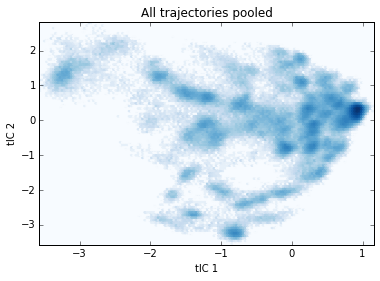

In [1]:
# basic imports
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

# load and process example data
from msmbuilder.example_datasets import FsPeptide
from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.decomposition import tICA

fs = FsPeptide().get().trajectories
n_atoms = fs[0].n_atoms

dih_model = DihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])
fs_dih_feat = dih_model.transform(fs)

tica = tICA(lag_time=100)
tica.fit(fs_dih_feat)

# X is a list of tica-transformed arrays, one per trajectory
X = tica.transform(fs_dih_feat)
# X_ is a vertically concatenated array of these
X_ = np.vstack(X)

# plot the 2D histogram of the data projected onto tIC 1 and tIC 2
plt.hexbin(X_[:,0],X_[:,1],bins='log',gridsize=150,cmap='Blues')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.title('All trajectories pooled')

Let's look at tIC1

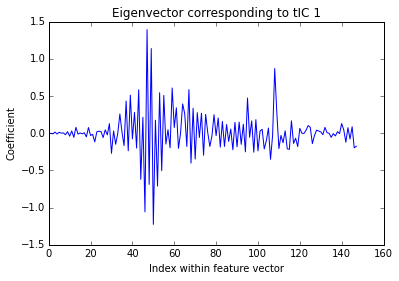

In [2]:
plt.title('Eigenvector corresponding to tIC 1')
plt.plot(tica.eigenvectors_[0])
plt.xlabel('Index within feature vector')
plt.ylabel('Coefficient')

We mostly care about the magnitudes here, so let's just look at the absolute value

47


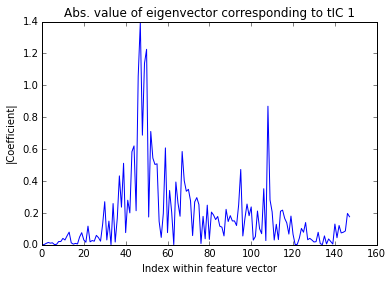

In [3]:
plt.title('Abs. value of eigenvector corresponding to tIC 1')
plt.plot(np.abs(tica.eigenvectors_[0]))
plt.xlabel('Index within feature vector')
plt.ylabel('|Coefficient|')
print(np.argmax(np.abs(tica.eigenvectors_[0])))

What are the standard deviations of the input features?

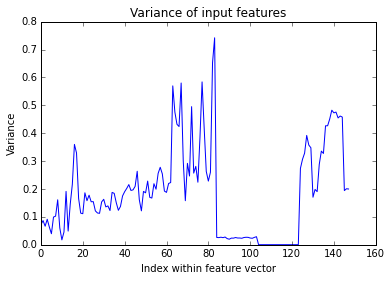

In [4]:
plt.title('Variance of input features')
plt.plot(np.vstack(fs_dih_feat).std(0)**2)
plt.xlabel('Index within feature vector')
plt.ylabel('Variance')

If the variance of an important input feature is high, then the model can still get away with using a small coefficient. We need to somehow account for that:

108


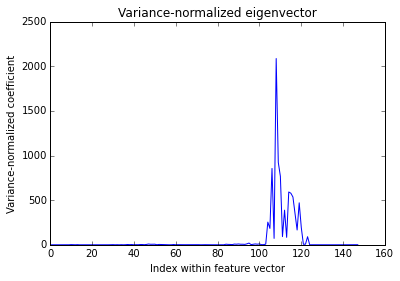

In [5]:
plt.plot(np.abs(tica.eigenvectors_[0])/np.vstack(fs_dih_feat).std(0)**2)
plt.title('Variance-normalized eigenvector')
plt.xlabel('Index within feature vector')
plt.ylabel('Variance-normalized coefficient')
print(np.argmax(np.abs(tica.eigenvectors_[0])/np.vstack(fs_dih_feat).std(0)**2))

Hmm this doesn't look quite right...

In [6]:
np.correlate(X_[:,0],np.vstack(fs_dih_feat)[:,0])[0]

-3074.3853715577807

In [7]:
corr_coefs = np.array([np.correlate(X_[:,0],np.vstack(fs_dih_feat)[:,i])[0] for i in range(X_.shape[1])])

77


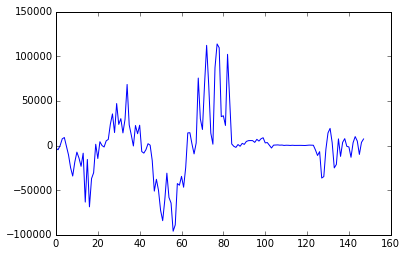

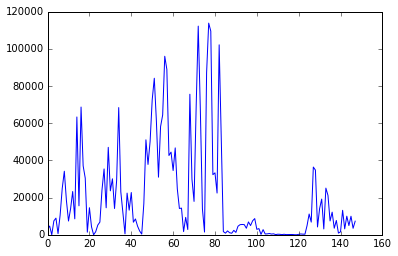

In [8]:
plt.plot(corr_coefs)
plt.figure()
plt.plot(np.abs(corr_coefs))
print(np.argmax(np.abs(corr_coefs)))

In [9]:
import mdtraj as md

In [10]:
# retrofitting the dihedral featurizer to keep track of which atoms correspond
# to which elements of the feature vector
class LabeledDihedralFeaturizer(DihedralFeaturizer):
    def partial_transform(self,traj):
        x = []
        self.labels = []
        self.atom_list = []
        
        for a in self.types:
            func = getattr(md, 'compute_%s' % a)
            atoms,y = func(traj)
            self.labels.append(a)
            if self.sincos:
                self.atom_list.append(np.vstack([atoms]*2))
                
                x.extend([np.sin(y), np.cos(y)])
            else:
                self.atom_list.append(atoms)
                
                x.append(y)

        self.atom_list = np.vstack(self.atom_list)
        return np.hstack(x)

In [11]:
labeled_dih_model = LabeledDihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])
fs_dih_feat = labeled_dih_model.transform(fs)

In [12]:
labeled_dih_model.atom_list.shape

(148, 4)

In [18]:
# now convert from a measure of feature importance to a measure of atom importance
atomwise_scores = np.zeros(n_atoms)
featurewise_scores = np.abs(corr_coefs)

for i,feature in enumerate(labeled_dih_model.atom_list):
    for atom in feature:
        atomwise_scores[atom] += featurewise_scores[i]
atomwise_scores /= np.max(atomwise_scores)

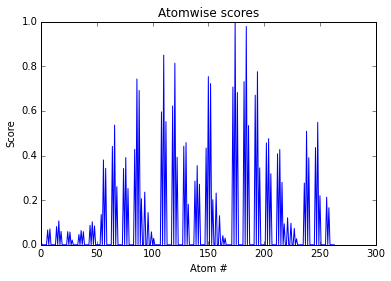

In [64]:
plt.plot(atomwise_scores)
plt.xlabel('Atom #')
plt.ylabel('Score')
plt.title('Atomwise scores')

In [60]:
# first few frames from trajectory 0, thinned by 2
traj = fs[0][::2][:200]
traj

<mdtraj.Trajectory with 200 frames, 264 atoms, 23 residues, without unitcells at 0x130b42050>

In [61]:
# saved with scores as b factors, to make it easy to color in pymol
traj.save_pdb('fs_peptide.pdb',bfactors=atomwise_scores)

Problem: this is difficult to view since the entire peptide tumbles around a lot. Let's align everything to a common reference...

In [66]:
traj.superpose(traj,len(traj)/2) # align to whatever the structure was in the middle of the trajectory
traj.save_pdb('fs_peptide.pdb',bfactors=atomwise_scores)